In [ ]:
Step 1: Load Necessary Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


In [ ]:
Step 2: Load and Preprocess Data for Text Model

In [2]:
# Load preprocessed text data
data_path = 'F:/MS Thesis/Research/BanglaText.csv'
df = pd.read_csv(data_path)

# Encode emotion labels
label_encoder = LabelEncoder()
df['Encoded_Emotion'] = label_encoder.fit_transform(df['Emotion'])
y = df['Encoded_Emotion']

# Tokenization and Padding
MAX_VOCAB_SIZE = 20000
MAX_SEQ_LEN = 100
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['Cleaned_Text'])

X_text = tokenizer.texts_to_sequences(df['Cleaned_Text'])
X_text = pad_sequences(X_text, maxlen=MAX_SEQ_LEN)

# Train-Test Split
X_train_text, X_temp, y_train, y_temp = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)
X_val_text, X_test_text, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [ ]:
Step 3: Define and Train the Bi-LSTM Model for Text


In [3]:
# Create Bi-LSTM model for text
model_text = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQ_LEN),
    Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)),
    Dense(6, activation='softmax')  # 6 emotions
])

model_text.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_text = model_text.fit(X_train_text, y_train, validation_data=(X_val_text, y_val), epochs=10, batch_size=32)


E:\python\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 49s 249ms/step - accuracy: 0.2026 - loss: 1.7797 - val_accuracy: 0.3900 - val_loss: 1.6222
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - accuracy: 0.5327 - loss: 1.3411 - val_accuracy: 0.5283 - val_loss: 1.2929
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 233ms/step - accuracy: 0.8073 - loss: 0.6268 - val_accuracy: 0.5433 - val_loss: 1.3329
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 237ms/step - accuracy: 0.9220 - loss: 0.2869 - val_accuracy: 0.5867 - val_loss: 1.3635
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.9496 - loss: 0.1932 - val_accuracy: 0.5767 - val_loss: 1.5669
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 237ms/step - accuracy: 0.9713 - loss: 0.1148 - val_accuracy: 0.5650 - val_loss: 1.6271
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 234ms/step - accuracy: 0.9680 - loss: 0.1081 - val_accuracy: 0.5617 - val_loss: 1.5945
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 235ms/step - accuracy: 0.9766 - loss: 0

In [ ]:
Step 4: Load and Preprocess Data for Voice Model

In [4]:
# Load feature and label data for voice model
X_voice = np.load('F:/MS Thesis/Research/Features/features.npy')  # Adjust path if needed
y_voice = np.load('F:/MS Thesis/Research/Features/labels.npy')  # Adjust path if needed

# Reshape data for CNN input
X_voice = X_voice.reshape((X_voice.shape[0], X_voice.shape[1], 1))  # Adjust dimensions

# Create a label mapping for voice
label_map = {label: idx for idx, label in enumerate(np.unique(y_voice))}
y_voice = np.array([label_map[label] for label in y_voice])

# Train-Test Split for voice
X_train_voice, X_temp_voice, y_train_voice, y_temp_voice = train_test_split(X_voice, y_voice, test_size=0.2, random_state=42, stratify=y_voice)
X_val_voice, X_test_voice, y_val_voice, y_test_voice = train_test_split(X_temp_voice, y_temp_voice, test_size=0.5, random_state=42, stratify=y_temp_voice)

# Convert labels to one-hot encoding
y_train_voice = to_categorical(y_train_voice)
y_val_voice = to_categorical(y_val_voice)
y_test_voice = to_categorical(y_test_voice)


In [ ]:
Step 5: Define and Train the CNN+Bi-LSTM Model for Voice

In [5]:
# Build CNN+Bi-LSTM model for voice
model_voice = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_voice.shape[1], X_train_voice.shape[2])),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Bidirectional(layers.LSTM(128, return_sequences=False)),
    layers.Dense(64, activation='relu'),
    layers.Dense(y_train_voice.shape[1], activation='softmax')  # Number of classes
])

model_voice.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_voice = model_voice.fit(X_train_voice, y_train_voice, validation_data=(X_val_voice, y_val_voice), epochs=30, batch_size=32)


E:\python\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.2355 - loss: 1.7306 - val_accuracy: 0.4083 - val_loss: 1.4690
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3952 - loss: 1.4452 - val_accuracy: 0.4133 - val_loss: 1.3925
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4473 - loss: 1.3683 - val_accuracy: 0.4817 - val_loss: 1.3079
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4702 - loss: 1.2879 - val_accuracy: 0.4883 - val_loss: 1.2506
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5129 - loss: 1.2208 - val_accuracy: 0.5167 - val_loss: 1.2118
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5245 - loss: 1.1916 - val_accuracy: 0.5400 - val_loss: 1.1618
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5346 - loss: 1.1601 - val_accuracy: 0.5367 - val_loss: 1.1723
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5549 - loss: 1.1064 - val_acc

In [ ]:
Step 6: Fusion Strategies

In [ ]:
Early Fusion (Feature-Level Fusion): Concatenate the features from both the text and voice models and train a new model.

In [13]:
# Get feature representations from both models
text_features = model_text.predict(X_train_text)
voice_features = model_voice.predict(X_train_voice)

# Concatenate features from text and voice
X_fused = np.concatenate([text_features, voice_features], axis=1)

# Create a new model for the fused features
fusion_model = Sequential([
    Dense(128, activation='relu', input_dim=X_fused.shape[1]),
    Dropout(0.3),
    Dense(6, activation='softmax')  # Number of emotions
])

fusion_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Split the fused data into training and validation sets
X_train_fusion, X_val_fusion, y_train_fusion, y_val_fusion = train_test_split(X_fused, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Train the fusion model with validation data
history_fusion = fusion_model.fit(
    X_train_fusion, y_train_fusion,  # Training data
    validation_data=(X_val_fusion, y_val_fusion),  # Validation data
    epochs=30,
    batch_size=32
)


150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


E:\python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6538 - loss: 1.4377 - val_accuracy: 0.9833 - val_loss: 0.4045
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9807 - loss: 0.2811 - val_accuracy: 0.9833 - val_loss: 0.0992
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9816 - loss: 0.1004 - val_accuracy: 0.9844 - val_loss: 0.0733
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9809 - loss: 0.0713 - val_accuracy: 0.9833 - val_loss: 0.0706
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9830 - loss: 0.0672 - val_accuracy: 0.9833 - val_loss: 0.0701
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9801 - loss: 0.0740 - val_accuracy: 0.9823 - val_loss: 0.0692
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9846 - loss: 0.0591 - val_accuracy: 0.9833 - val_loss: 0.0659
Epoch 8/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9838 - loss: 0.0591 - val_accuracy: 0.

In [ ]:
Late Fusion (Decision-Level Fusion): Combine the predictions from both models.

In [20]:
# Predict using both models (text and voice)
y_pred_text = model_text.predict(X_test_text)
y_pred_voice = model_voice.predict(X_test_voice)

# Average the predictions for fusion (Late Fusion approach)
y_pred_fusion = (y_pred_text + y_pred_voice) / 2

# Get the final predicted labels
y_pred_labels_fusion = np.argmax(y_pred_fusion, axis=1)

# Training Late Fusion model
late_fusion_model = Sequential([
    Dense(128, activation='relu', input_dim=y_pred_fusion.shape[1]),  # Input shape for averaged prediction
    Dropout(0.3),
    Dense(6, activation='softmax')  # 6 emotions for classification
])

late_fusion_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the Late Fusion model
history_late_fusion = late_fusion_model.fit(y_pred_fusion, y_test, epochs=30, batch_size=32, validation_split=0.2)

# Now you can plot using the `history_late_fusion` object


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


E:\python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2677 - loss: 1.7683 - val_accuracy: 0.5750 - val_loss: 1.6951
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4899 - loss: 1.6715 - val_accuracy: 0.8083 - val_loss: 1.5940
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6767 - loss: 1.5709 - val_accuracy: 0.8333 - val_loss: 1.4921
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7528 - loss: 1.4674 - val_accuracy: 0.8083 - val_loss: 1.3878
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7787 - loss: 1.3534 - val_accuracy: 0.8000 - val_loss: 1.2801
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 1.2444 - val_accuracy: 0.8083 - val_loss: 1.1718
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7383 - loss: 1.1641 - val_accuracy: 0.8083 - val_loss: 1.0734
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7467 - loss: 1.0894 - val_accuracy: 0.8167 - v

In [ ]:
Hybrid Fusion (Combination of Early and Late Fusion): First, concatenate features and then apply decision-level fusion.

150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6068 - loss: 1.4919 - val_accuracy: 0.9865 - val_loss: 0.4130
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9830 - loss: 0.2941 - val_accuracy: 0.9865 - val_loss: 0.0867
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9820 - loss: 0.1011 - val_accuracy: 0.9865 - val_loss: 0.0593
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9805 - loss: 0.0762 - val_accuracy: 0.9865 - val_loss: 0.0540
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9839 - loss: 0.0675 - val_accuracy: 0.9865 - val_loss: 0.0529
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9816 - loss: 0.0767 - val_accuracy: 0.9865 - val_loss: 0.0520
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9820 - loss: 0.0657 - val_accuracy: 0.9865 - val_loss: 0.0519
Epoch 8/30
120/120 

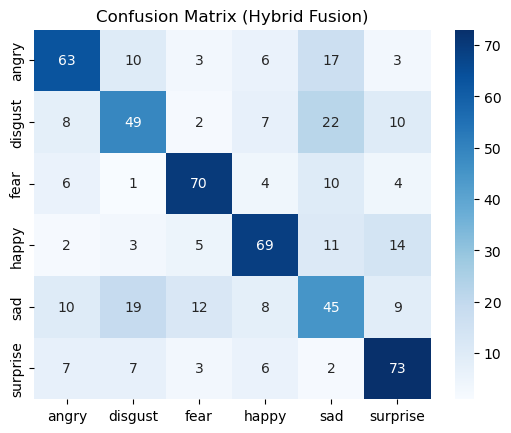

In [21]:
# Concatenate features from text and voice models for training
text_features = model_text.predict(X_train_text)
voice_features = model_voice.predict(X_train_voice)
X_fused_hybrid = np.concatenate([text_features, voice_features], axis=1)

# Train a fusion model on the concatenated features
hybrid_model = Sequential([
    Dense(128, activation='relu', input_dim=X_fused_hybrid.shape[1]),
    Dropout(0.3),
    Dense(6, activation='softmax')  # Number of classes
])

hybrid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Split training data to validation for plotting
X_train_fusion, X_val_fusion, y_train_fusion, y_val_fusion = train_test_split(X_fused_hybrid, y_train, test_size=0.2, random_state=42)

# Train the hybrid fusion model
history_hybrid = hybrid_model.fit(X_train_fusion, y_train_fusion, validation_data=(X_val_fusion, y_val_fusion), epochs=30, batch_size=32)

# Evaluate the hybrid fusion model on the test set
X_fused_test_hybrid = np.concatenate([model_text.predict(X_test_text), model_voice.predict(X_test_voice)], axis=1)
y_pred_hybrid = hybrid_model.predict(X_fused_test_hybrid)

# Classification Report and Confusion Matrix for Hybrid Fusion
y_pred_labels_hybrid = np.argmax(y_pred_hybrid, axis=1)
print(classification_report(y_test, y_pred_labels_hybrid, target_names=label_encoder.classes_))

cm_hybrid = confusion_matrix(y_test, y_pred_labels_hybrid)
sns.heatmap(cm_hybrid, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Hybrid Fusion)')
plt.show()




In [ ]:
Step 7: Evaluate and Compare Results

In [ ]:
Step 7.1: Evaluate Each Fusion Strategy

In [ ]:
Step 7.1.1 :Classification Report for Early Fusion

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report for Early Fusion:
              precision    recall  f1-score   support

       angry       0.98      0.99      0.99       817
     disgust       0.98      0.98      0.98       782
        fear       0.99      0.98      0.99       756
       happy       0.99      0.99      0.99       837
         sad       0.98      0.97      0.97       824
    surprise       0.97      0.98      0.98       784

    accuracy                           0.98      4800
   macro avg       0.98      0.98      0.98      4800
weighted avg       0.98      0.98      0.98      4800



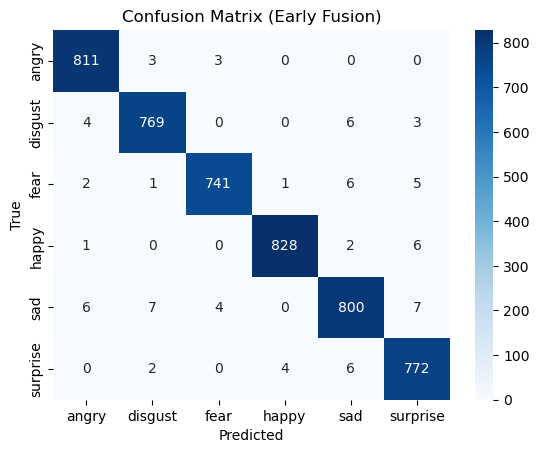

In [22]:
# Get predictions for early fusion
y_pred_fusion_early = fusion_model.predict(X_fused)
y_pred_labels_fusion_early = np.argmax(y_pred_fusion_early, axis=1)

# Classification Report for Early Fusion
print("\nClassification Report for Early Fusion:")
print(classification_report(y_train, y_pred_labels_fusion_early, target_names=label_encoder.classes_))

# Confusion Matrix for Early Fusion
cm_early = confusion_matrix(y_train, y_pred_labels_fusion_early)
sns.heatmap(cm_early, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Early Fusion)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
7.1.2: Classification Report for Late Fusion


Classification Report for Late Fusion:
              precision    recall  f1-score   support

       angry       0.80      0.77      0.79       102
     disgust       0.80      0.70      0.75        98
        fear       0.88      0.85      0.87        95
       happy       0.89      0.76      0.82       104
         sad       0.73      0.81      0.76       103
    surprise       0.72      0.89      0.80        98

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600



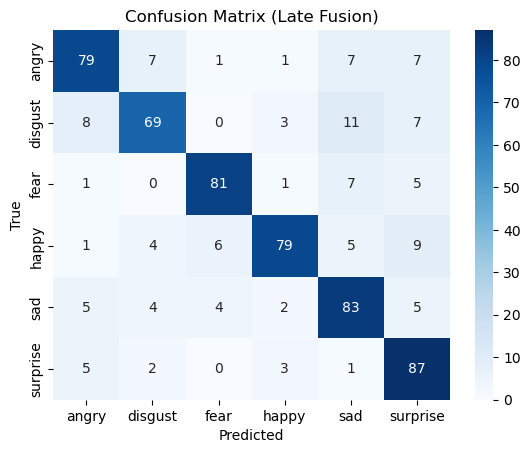

In [23]:
# Get predictions for late fusion
y_pred_fusion_late = (y_pred_text + y_pred_voice) / 2
y_pred_labels_fusion_late = np.argmax(y_pred_fusion_late, axis=1)

# Classification Report for Late Fusion
print("\nClassification Report for Late Fusion:")
print(classification_report(y_test, y_pred_labels_fusion_late, target_names=label_encoder.classes_))

# Confusion Matrix for Late Fusion
cm_late = confusion_matrix(y_test, y_pred_labels_fusion_late)
sns.heatmap(cm_late, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Late Fusion)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
7.1.3 Classification Report for Hybrid Fusion

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Classification Report for Hybrid Fusion:
              precision    recall  f1-score   support

       angry       0.66      0.62      0.64       102
     disgust       0.55      0.50      0.52        98
        fear       0.74      0.74      0.74        95
       happy       0.69      0.66      0.68       104
         sad       0.42      0.44      0.43       103
    surprise       0.65      0.74      0.69        98

    accuracy                           0.61       600
   macro avg       0.62      0.62      0.62       600
weighted avg       0.62      0.61      0.61       600



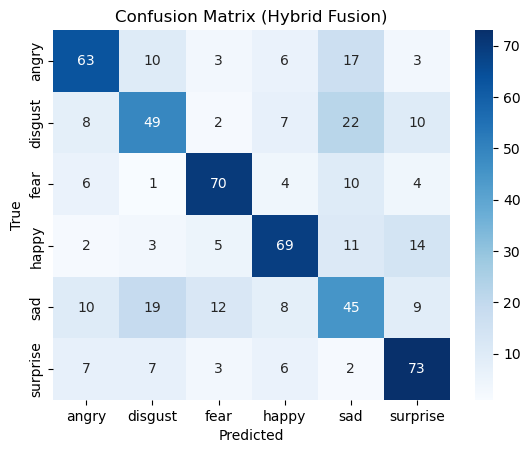

In [24]:
# Get predictions for hybrid fusion
y_pred_hybrid = hybrid_model.predict(X_fused_test_hybrid)
y_pred_labels_hybrid = np.argmax(y_pred_hybrid, axis=1)

# Classification Report for Hybrid Fusion
print("\nClassification Report for Hybrid Fusion:")
print(classification_report(y_test, y_pred_labels_hybrid, target_names=label_encoder.classes_))

# Confusion Matrix for Hybrid Fusion
cm_hybrid = confusion_matrix(y_test, y_pred_labels_hybrid)
sns.heatmap(cm_hybrid, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Hybrid Fusion)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
Step 7.2: Plot Accuracy Curves for Individual Models and Fusion Models

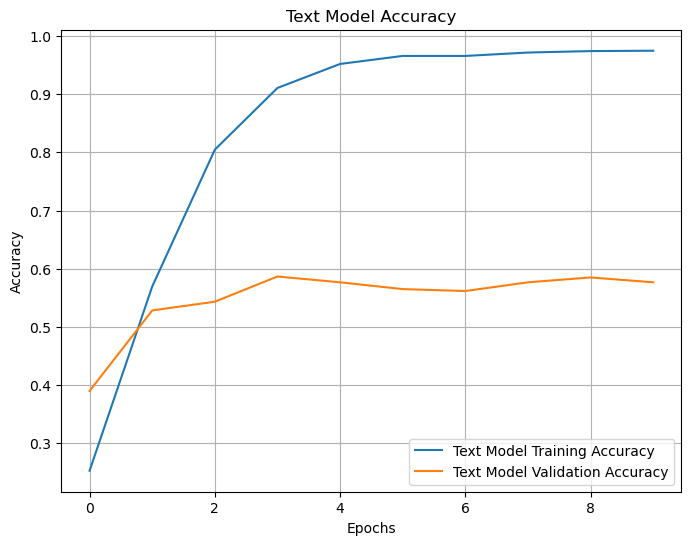

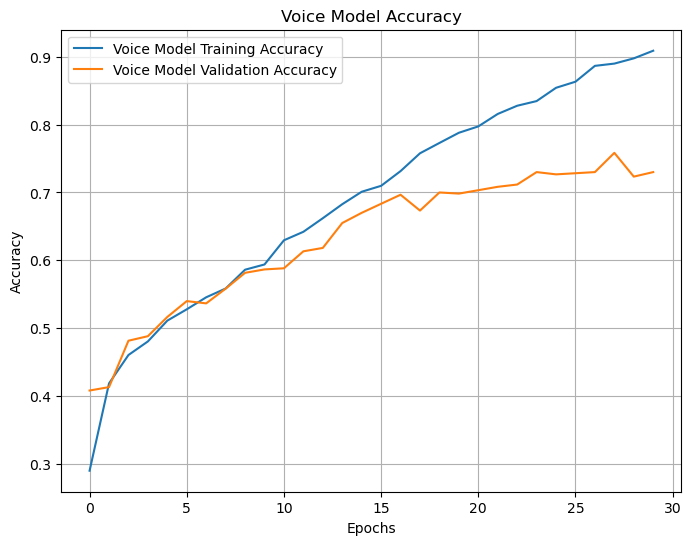

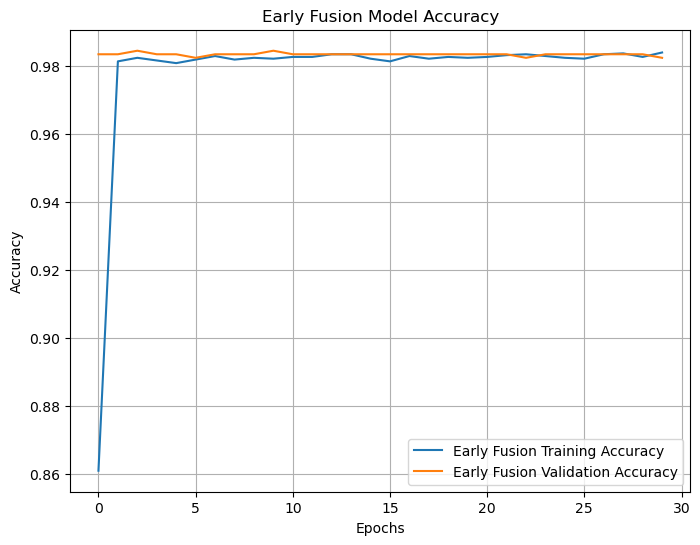

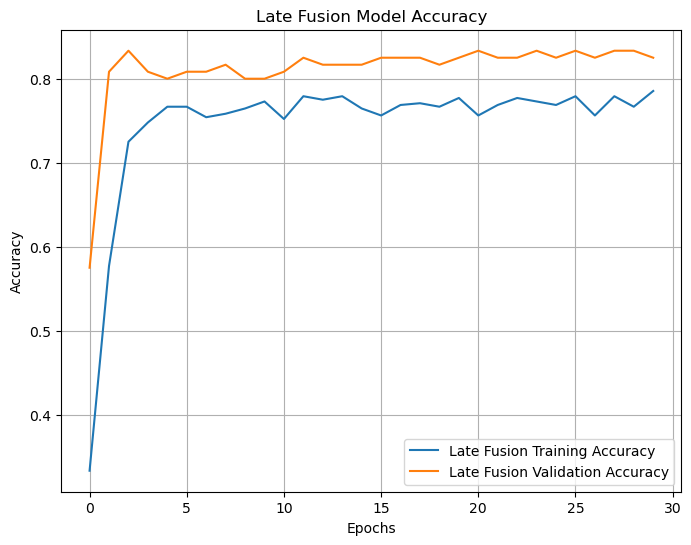

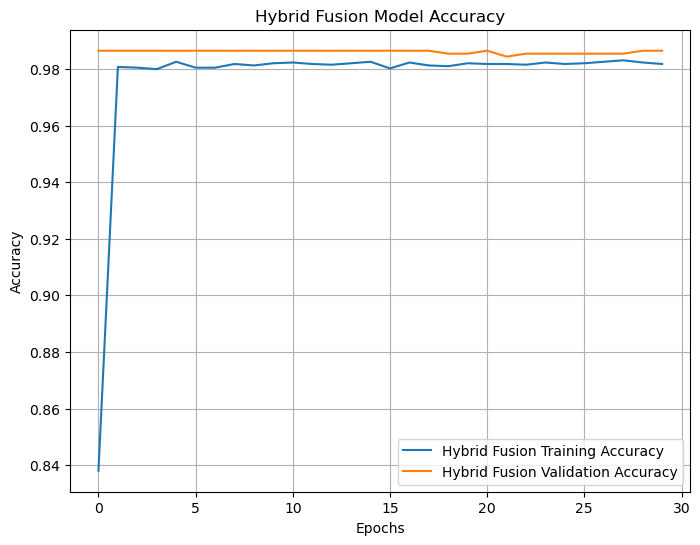

In [26]:
# Plot Accuracy Curve for Text Model
plt.figure(figsize=(8, 6))
plt.plot(history_text.history['accuracy'], label='Text Model Training Accuracy')
plt.plot(history_text.history['val_accuracy'], label='Text Model Validation Accuracy')
plt.title('Text Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Curve for Voice Model
plt.figure(figsize=(8, 6))
plt.plot(history_voice.history['accuracy'], label='Voice Model Training Accuracy')
plt.plot(history_voice.history['val_accuracy'], label='Voice Model Validation Accuracy')
plt.title('Voice Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Curve for Early Fusion Model
plt.figure(figsize=(8, 6))
plt.plot(history_fusion.history['accuracy'], label='Early Fusion Training Accuracy')
plt.plot(history_fusion.history['val_accuracy'], label='Early Fusion Validation Accuracy')
plt.title('Early Fusion Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Curve for Late Fusion Model
plt.figure(figsize=(8, 6))
plt.plot(history_late_fusion.history['accuracy'], label='Late Fusion Training Accuracy')
plt.plot(history_late_fusion.history['val_accuracy'], label='Late Fusion Validation Accuracy')
plt.title('Late Fusion Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Curve for Hybrid Fusion Model
plt.figure(figsize=(8, 6))
plt.plot(history_hybrid.history['accuracy'], label='Hybrid Fusion Training Accuracy')
plt.plot(history_hybrid.history['val_accuracy'], label='Hybrid Fusion Validation Accuracy')
plt.title('Hybrid Fusion Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
from sklearn.metrics import precision_recall_fscore_support

# Precision, Recall, F1-Score for Early Fusion
# Ensure y_pred_labels_fusion_early is defined after Early Fusion model prediction
precision_early, recall_early, f1_early, _ = precision_recall_fscore_support(y_train, y_pred_labels_fusion_early, average='weighted')
print(f"Early Fusion - Precision: {precision_early:.2f}, Recall: {recall_early:.2f}, F1-Score: {f1_early:.2f}")

# Precision, Recall, F1-Score for Late Fusion
# Ensure y_pred_labels_fusion_late is defined after Late Fusion model prediction
precision_late, recall_late, f1_late, _ = precision_recall_fscore_support(y_test, y_pred_labels_fusion_late, average='weighted')
print(f"Late Fusion - Precision: {precision_late:.2f}, Recall: {recall_late:.2f}, F1-Score: {f1_late:.2f}")

# Precision, Recall, F1-Score for Hybrid Fusion
# Ensure y_pred_labels_hybrid is defined after Hybrid Fusion model prediction
precision_hybrid, recall_hybrid, f1_hybrid, _ = precision_recall_fscore_support(y_test, y_pred_labels_hybrid, average='weighted')
print(f"Hybrid Fusion - Precision: {precision_hybrid:.2f}, Recall: {recall_hybrid:.2f}, F1-Score: {f1_hybrid:.2f}")


Early Fusion - Precision: 0.98, Recall: 0.98, F1-Score: 0.98
Late Fusion - Precision: 0.80, Recall: 0.80, F1-Score: 0.80
Hybrid Fusion - Precision: 0.62, Recall: 0.61, F1-Score: 0.61


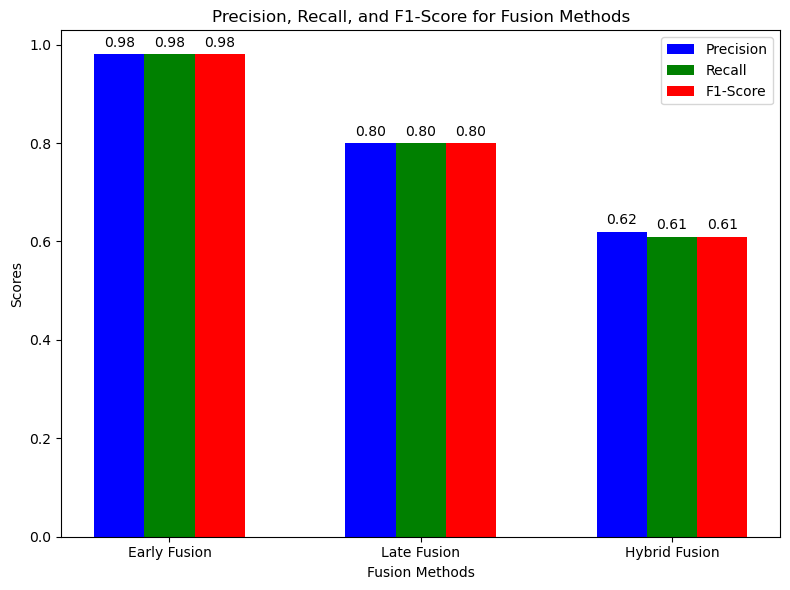

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Precision, Recall, and F1-Score
fusion_methods = ['Early Fusion', 'Late Fusion', 'Hybrid Fusion']
precision_scores = [0.98, 0.80, 0.62]
recall_scores = [0.98, 0.80, 0.61]
f1_scores = [0.98, 0.80, 0.61]

# Set position of bars on x-axis
x = np.arange(len(fusion_methods))

# Set the width of the bars
width = 0.2

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting the bars for Precision, Recall, and F1-Score
bars1 = ax.bar(x - width, precision_scores, width, label='Precision', color='b')
bars2 = ax.bar(x, recall_scores, width, label='Recall', color='g')
bars3 = ax.bar(x + width, f1_scores, width, label='F1-Score', color='r')

# Add text labels above the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to the bars
add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Set the labels and title
ax.set_xlabel('Fusion Methods')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for Fusion Methods')
ax.set_xticks(x)
ax.set_xticklabels(fusion_methods)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
1. Early Fusion: Combining features from multiple modalities (text and voice) at the input stage and training the model on the fused data.
 
2. Late Fusion: Combining predictions from individual models (text and voice) after training, to make the final decision.
    
3. Hybrid Fusion: A combination of early and late fusion, using both feature-level and prediction-level fusion for improved performance.

In [32]:
fusion_model.summary()  # For early fusion
late_fusion_model.summary()  # Late Fusion model summary
hybrid_model.summary()  # For hybrid fusion


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 128)                 │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,316 (28.58 KB)

 Trainable params: 2,438 (9.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,878 (19.06 KB)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (None, 128)                 │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 1,670 (6.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,342 (13.06 KB)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                     │ (None, 128)                 │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,316 (28.58 KB)

 Trainable params: 2,438 (9.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,878 (19.06 KB)